# Clustering

Application/ use cases:<br>
1) Customer Segmentation<br>
2) Data Analysis: Analyzing a new dataset by performing clustering algorithm.<br>
3) Dimensionality reduction: The features are replaced by the cluster affinities. Affinity measures how instances fit into a cluster.<br>
4) Feature engineering: Cluster affinities can also be used as extra features.<br>
5) Anomaly detection: Instances that have low affinity to all the cluster are considered outliers.<br>
6) Semi-supervised learning: You can cluster the instances and propagate the labels to all the instances in the same cluster.<br>
7) Search engines: Search for similar images that the user has provided. You already have a trained clustering model and all you have to find is the provided image's cluster.<br>
8) Image segmentation: Cluster the pixels according to their colors and then replace each pixel's color with the mean color of the cluster.

# 1) k-means

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, n_init=15, random_state=42)
y_pred = kmeans.fit_predict(X)

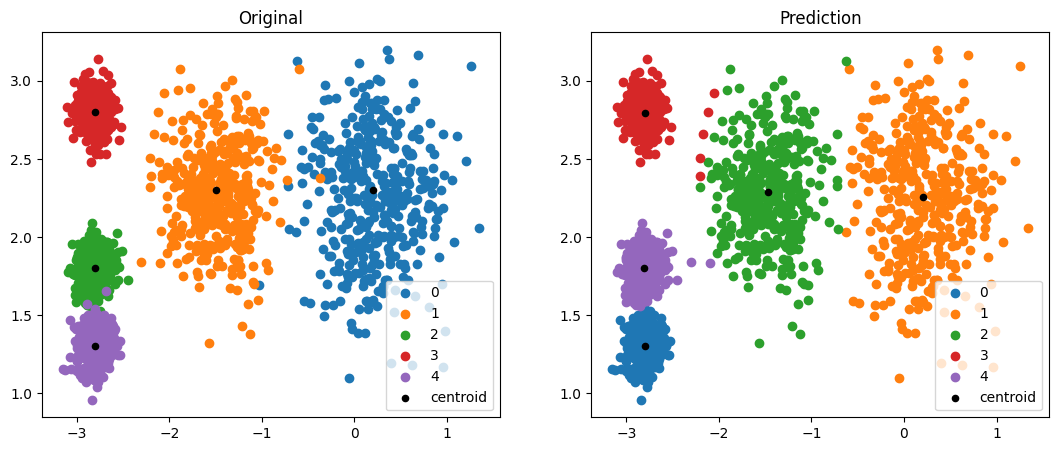

In [3]:
fig1, ax = plt.subplots(figsize = (13,5), nrows=1, ncols=2)
for g in np.unique(y):
    index = np.where(y == g)
    ax[0].scatter(X[index,0], X[index,1], label = g)

ax[0].scatter(blob_centers[:,0], blob_centers[:,1], c='black', s=20, label = 'centroid')
ax[0].set_title("Original")
ax[0].legend()

for g in np.unique(y_pred):
    index = np.where(y_pred == g)
    ax[1].scatter(X[index,0], X[index,1], label = g)
ax[1].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', s=20, label = 'centroid')
ax[1].set_title('Prediction')
ax[1].legend()

In [4]:
X_new = [[0, 2], [-2, 1]]
print(kmeans.predict(X_new))
print(kmeans.transform(X_new))

[1 0]
[[2.88633901 0.32995317 1.49439034 2.9042344  2.81093633]
 [0.85504298 2.54065898 1.39202218 1.96361565 1.13496186]]


### Centroid initialization

1) You can set 'init' hyperparameter to desired centroid locations if you already have a idea where your centroids are located.<br>
2) The 'n_init' hyperparameter sets the number of times the model will try to fit data, each time with new random initialization of centroids. The models are then compared with each other on their 'inertia' values which is nothing but the squared distances between centroids and the instances.

In [5]:
kmeans.inertia_

211.59853725816836

In [6]:
kmeans.score(X)

-211.59853725816834

3) k-means++, as proposed in a 2006 paper by David Arthur and Sergei Vassilvitskii which is the default method for KMeans class. The algorithm goes as follows:<br>
•   Choose one centroid randomly from dataset.<br>
•	Then find a nearest, already selected centroid, for each training instance. Get the squared distance values for each training instance. Make the instance a new centroid which has the greatest squared distance amongst them.<br>
•   Repeat step 2 until required number of centroids are found.

### Training on Mini-batches

We use this because it is almost 3.5 times faster than regular k-means but it has slightly worse inertia.

In [7]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

You may also use the memmap class as it was discussed in Chapter 8: PCA on page 251 if the data is too large.

### Finding optimal number of clusters

#### Elbow method on inertia vs cluster graph

You may think that the model with lowest inertia should always be choosen. But thats not the correct assumption. As we increase number of clusters, the inertia always decreases. However, you may use the elbow technique to get a rough estimate.

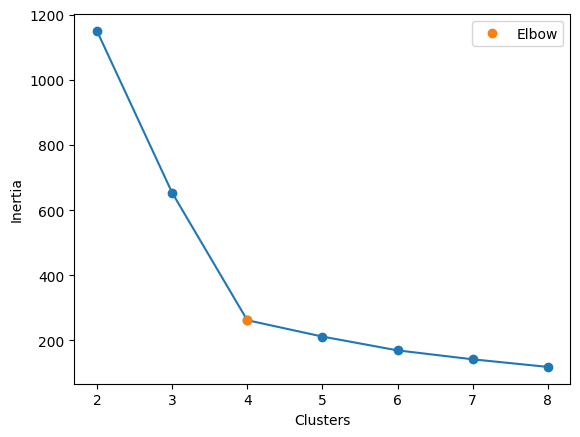

In [8]:
clusters = [i for i in range (2,9)]
models = [KMeans(n_clusters=k, n_init=15, random_state=42).fit(X) for k in clusters]
labels = [model.predict(X) for model in models]
inertia = [model.inertia_ for model in models]

plt.plot(range(2, 9), inertia)

plt.plot([4], inertia[2], 'o', label = 'Elbow')
plt.scatter(range(2, 9), inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.legend()

#### Silhouette score

It is the mean silhouette coefficient over all instances. Silhouette coefficient is equal to (b - a)/max(a,b). Here, a is the mean distance to other instances in the same cluster while b is the mean distance to other instances in the next closest cluster. The closest cluster is the one that minimizes b.

A score of 1 means the instance is well inside its own cluster. A score of 0 means the instance is on the boundary of its cluster while a score of -1 means the instance is assigned to the wrong cluster.


In [9]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

print(silhouette_score(X, kmeans.labels_))
print(silhouette_samples(X, kmeans.labels_).mean())

0.655517642572828
0.655517642572828


Text(0, 0.5, 'Silhouette Score')

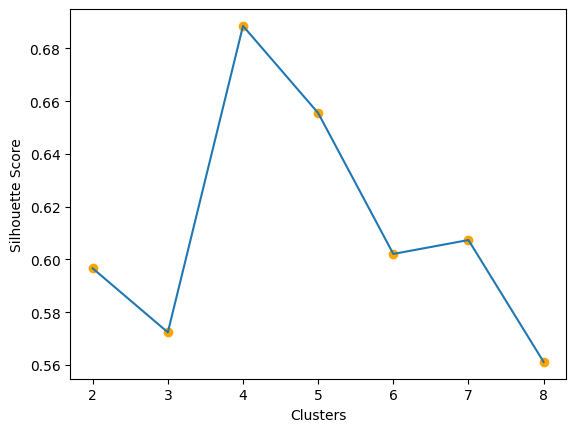

In [10]:
scores = [silhouette_score(X, model.labels_) for model in models]
samples = [silhouette_samples(X, model.labels_) for model in models]

plt.plot(range(2,9), scores)
plt.scatter(range(2,9), scores, c='orange')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')

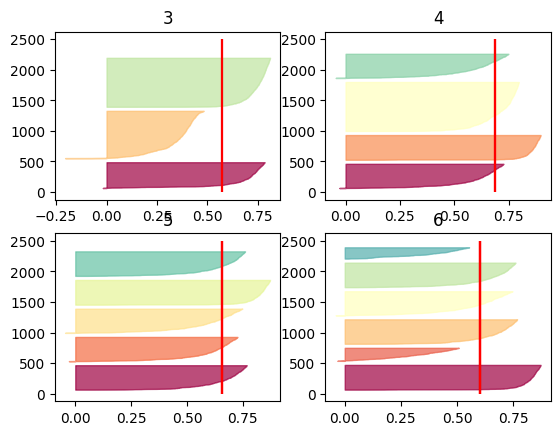

In [11]:
for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    y_pred = labels[k-2]
    silhouette_coefficients = samples[k-2]

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                            facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
        plt.vlines(scores[k - 2], 0, 2500, colors='red')
        plt.title(k)

As you can see, for graph with clusters = 4, even though most instances extend beyond the vertical line, the width of the cluster is not consistent. However, for the graph of clusters = 5, we can see that the clusters are of similar sizes and hence this will be our choice.


# Application: Clustering for image segmentation

1) Color segmentation: All the pixels with similar colors are assigned same segment. Example is of satellite image trying to measure total forest area.<br>
2) Semantic segmentation: Pixels of same object are segmented as one. Example, a pedestrian's image in a car's self driving vision system. There will be one segment that only has pedestrains.<br>
3) Instance segmentation: Pixels of same individual are assigned to same segments. Different segment for each pedestrian.<br><br>

Today these are achieved through complex architectures such as convolution neural nets. Here is a simpler way to do color segmentation.

In [12]:
import urllib.request
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = IMAGES_PATH / filename

if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

import PIL
image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

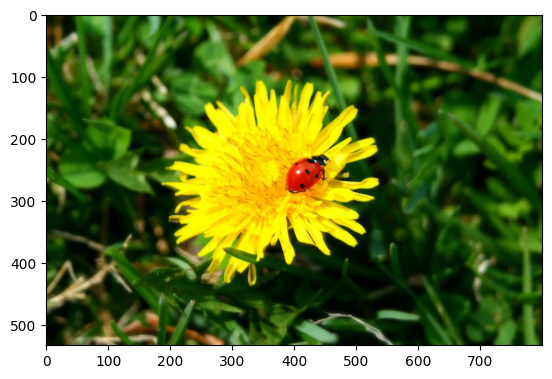

In [13]:
plt.imshow(image)

In [14]:
X = image.reshape(-1, 3)

In [15]:
kmeans = KMeans(n_clusters=8, n_init=20, random_state=42)
kmeans.fit(X)

KMeans(n_init=20, random_state=42)

Text(0.5, 1.0, '8 colors')

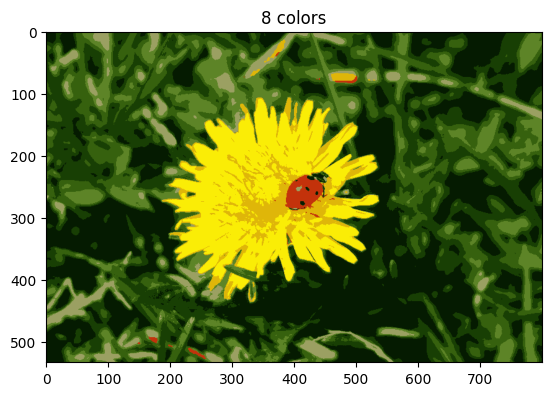

In [16]:
segmented_image = kmeans.cluster_centers_[kmeans.labels_]
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image / 255)
plt.title('8 colors')

In [17]:
array = np.array([7,6,5,4,3,2,1])

In [18]:
kmeans.cluster_centers_[[0,1,0]]

array([[  5.6105612 ,  27.61743918,   1.44857047],
       [250.68280046, 237.8319458 ,   6.51237711],
       [  5.6105612 ,  27.61743918,   1.44857047]])

# Application: Clustering for Semi-supervised Learning

In [19]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

Here we will imagine that we only were able to label 50 random instance out of all the 1700+ instances.

In [20]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50

log_reg = LogisticRegression(max_iter=10000, random_state = 42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

log_reg.score(X_test, y_test)

0.7581863979848866

In [21]:
kmeans = KMeans(n_clusters=50, n_init=10, random_state=42)
kmeans.fit(X_train)
digits_dist_from_each_cluster = kmeans.fit_transform(X_train)
represent_id = np.argmin(digits_dist_from_each_cluster, axis=0)
X_represent = X_train[represent_id]

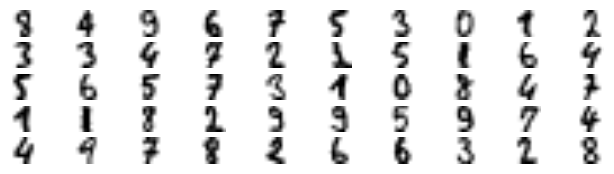

In [22]:
plt.figure(figsize=(8, 2))
for index, represent in enumerate(X_represent):
    plt.subplot(50 // 10, 10, index + 1)
    plt.imshow(represent.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

In [23]:
y_represent = y_train[represent_id]

(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

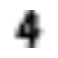

In [24]:
plt.figure(figsize=(0.5,0.5))
plt.imshow(X_represent[1].reshape(8,8), cmap='binary', interpolation='bilinear')
plt.axis('off')

In [25]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_represent, y_represent)
log_reg.score(X_test, y_test)

0.8387909319899244

Since  it  is  often  costly  and  painful  to  label  instances, especially  when  it  has  to  be  done  manually  by  experts,  it  is  a  good  idea  to  label  representative instances rather than just random instances. The results show that the 50 instances that were more representative of the data, performed better.

We may also try to propagate the labels to all the instances in each cluster and see how it performs.

In [26]:
y_propagated = np.empty(y_train.size)
for i in range(50):
    y_propagated[np.where(kmeans.labels_ == i)] = y_represent[i]

In [27]:
log_reg = LogisticRegression(max_iter = 10000)
log_reg.fit(X_train, y_propagated)
log_reg.score(X_test, y_test)

0.8589420654911839

### Finding outliers with kmeans

Now we may try to eliminate the instances that are outliers i.e. they are the 1% instances that are farthest from their clusters.

In [28]:
closest_cluster_distances = digits_dist_from_each_cluster[range(0,1400), kmeans.labels_]
outlier = np.array([])

for k in range(50):
    cluster_dist = closest_cluster_distances[kmeans.labels_ == k]
    above = np.percentile(cluster_dist, 99)
    closest_cluster_distances[np.where((kmeans.labels_ == k) & (closest_cluster_distances > above))] = -1
    
not_outliers = np.where(closest_cluster_distances[closest_cluster_distances != -1])

log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train[not_outliers], y_propagated[not_outliers])
log_reg.score(X_test, y_test)

0.8589420654911839

In [29]:
(y_propagated[not_outliers] == y_train[not_outliers]).mean()

np.float64(0.9481481481481482)

Also see the following:

In [30]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

from sklearn.semi_supervised import SelfTrainingClassifier

# 2) DBSCAN

DBSCAN stands for density-based spatial clustring of applications with noise. It basically works as follows: <br>
1) For each instance, within a small region called instance's e-neighborhood, the algorithm tries to find number of other instances within a small distance, epsilon (e). <br>
2) If they are greater than a certain number, min_samples, then it is a core instance and hence it is located in dense region. <br>
3) All instances in the neighborhood of core instances are included in the same cluster. A long series of neighboring core instances form a single cluster. <br>
4) Any instance who is not a core instance and does not have one in its neighborhood is considered an anomaly.<br><br>

DBSCAN works best with low density regions.

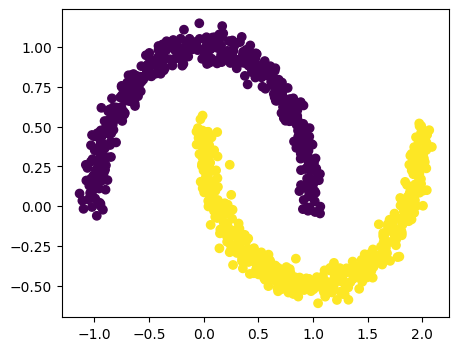

In [31]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise = 0.05)

plt.figure(figsize=(5,4))
plt.scatter(X[:,0], X[:,1], c=y)

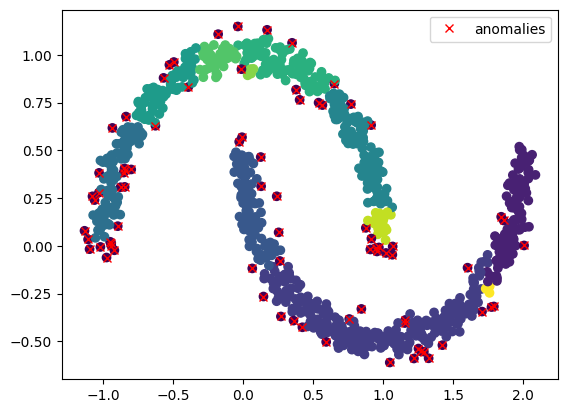

In [68]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

dbscan.labels_
dbscan.core_sample_indices_
dbscan.components_ # it is the values at the indices that are available from the method core_samples_indices_
plt.scatter(X[:,0], X[:,1], c=dbscan.labels_)
#plt.plot(dbscan.components_[:,0], dbscan.components_[:,1], 'r.', label = 'core')
plt.plot(X[dbscan.labels_ == -1][:,0], X[dbscan.labels_ == -1][:,1], 'rx', label = 'anomalies')
plt.legend()

This is how you find clusters. However, there is no predict function, even though there is fit_predict function. But its not hard to implement.

### Using KNN to predict for new data

In [74]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors = 50)
knn_clf.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

You can choose to train KNN on the core components only or you may choose to train it on core components + anomalies. It is all upto you!

In [75]:
X_new = np.array([[-0.5,0],[0,0.5],[1,-0.1],[2,1]])
knn_clf.predict(X_new)

array([3, 2, 9, 0])

Right now the algorithm does not identify any anomalies and always chooses a cluster. We may introduce a maximum distance from clusters in which case if they are beyond that, they are considered anomalies.<br><br>

### Finding outliers with DBSCAN and KNN

<br>
Given a set of instances, the 'kneighbors' function returns the distances and the indices of the k-nearest neighbors in the training set (two matrices, each with k columns).

In [129]:
y_dist, y_pred_idx = knn_clf.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
X_nearest = dbscan.components_[y_pred_idx]

y_pred[y_dist > 0.2] = -1
y_pred

array([[-1],
       [ 2],
       [ 9],
       [-1]])

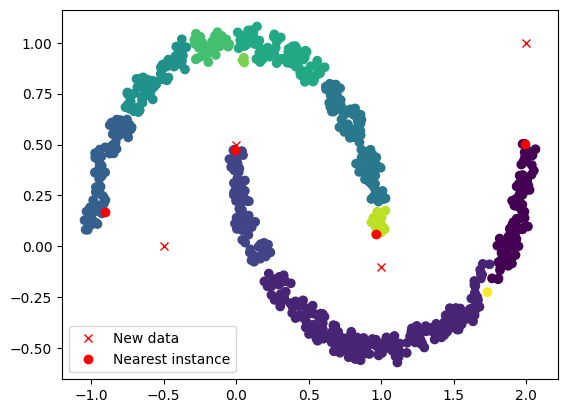

In [128]:
plt.scatter(dbscan.components_[:,0], dbscan.components_[:,1], c = dbscan.labels_[dbscan.core_sample_indices_])
plt.plot(X_new[:,0], X_new[:,1], 'rx', label = 'New data')
plt.plot(X_nearest[:,0][:,0], X_nearest[:,0][:,1], 'ro', label = 'Nearest instance')
plt.legend()

In [130]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift
from sklearn.cluster import AffinityPropagation

# Gaussian Mixtures

A  Gaussian  mixture  model  (GMM)  is  a  probabilistic  model  that  assumes  that  the  instances  were  generated  from  a  mixture  of  several  Gaussian  distributions  whose  parameters  are  unknown.  All  the  instances  generated  from  a  single  Gaussian  distribution  form  a  cluster  that  typically  looks  like  an  ellipsoid.<br><br>

In the GradientMixture class, you are ought to already know the number k of Gaussian distributions. A cluster's weight is equal to the probability of choosing that cluster. If an instance is assigned a certain cluster, its location is sampled randomly from Gaussian distribution with a certain mean and covariance.<br><br>

This  class  relies  on  the  expectation-maximization (EM) algorithm. The clusters are first initialized randomly. The expectation step is to assign clusters to each instance. For the maximization step, each cluster is updated using all instances. In  the  context  of  clustering,  you  can think  of  EM  as  a  generalization  of  k-means that  not  only  finds  the  cluster  centers  (μ(1)  to  μ(k)),  but  also  their  size,  shape,  and  orientation (Σ(1) to Σ(k)), as well as their relative weights (φ(1) to φ(k)).

In [5]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [6]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 3, n_init = 10, random_state=42)
gm.fit(X)

gm.weights_
gm.means_
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

In [7]:
print(gm.converged_)
print(gm.n_iter_)

True
4


In [8]:
gm.predict(X) # hard clustering
gm.predict_proba(X) # soft clustering

array([[6.76282339e-07, 2.31833274e-02, 9.76815996e-01],
       [6.74575575e-04, 1.64110061e-02, 9.82914418e-01],
       [9.99922764e-01, 1.99781831e-06, 7.52377580e-05],
       ...,
       [2.12540639e-26, 9.99999568e-01, 4.31902443e-07],
       [1.45002917e-41, 1.00000000e+00, 5.20915318e-16],
       [7.93266114e-41, 1.00000000e+00, 2.30971331e-15]])

This is also a generative model meaning you can sample new instances.

In [9]:
gm.sample(3)

(array([[-2.32491052,  1.04752548],
        [ 3.6102959 ,  0.79319611],
        [ 1.84860618,  2.07374016]]),
 array([0, 1, 1]))

You may also find the density of model with 'score_samples' method. These values are the log of the probability denisty function. Integrate the pdf over a particular area to get the probabilities.

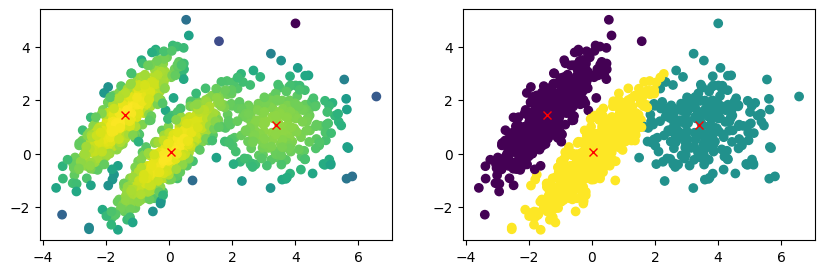

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(3)
ax[0].plot(gm.means_[:,0], gm.means_[:,1], 'rx')
ax[0].scatter(X[:,0], X[:,1], c = gm.score_samples(X).round(2))
ax[1].scatter(X[:,0], X[:,1], c = gm.predict(X))
ax[1].plot(gm.means_[:,0], gm.means_[:,1], 'rx')

### Limiting shapes of data

However, the data will not always be low-dimensional and of Gaussian nature. We also knew the number of clusters. We might need to reduce parameters the algorithm have to learn. One way is to limit shapes of data. Set the hyperparameter, 'covariance_type' to:<br>
1) spherical: clusters are all spherical<br>
2) diag: clusters are only ellipsoidal but there axis must be parallel to coordinate axes.<br>
3) tied: all clusters must have same ellipsoidal shape, size etc.<br>
4) full: clusters can have any shape, size etc.<br>

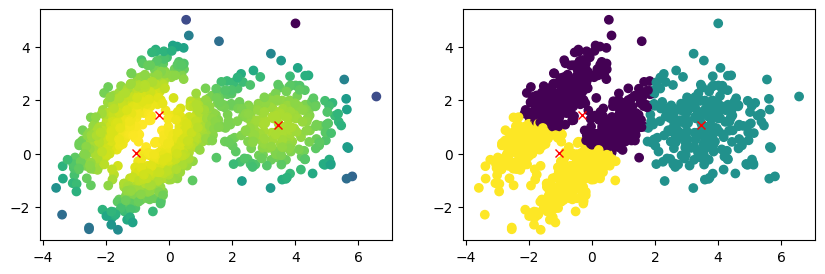

In [11]:
gm_temp = GaussianMixture(n_components = 3, n_init = 10, random_state=42, covariance_type='spherical')
gm_temp.fit(X)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(3)
ax[0].plot(gm_temp.means_[:,0], gm_temp.means_[:,1], 'rx')
ax[0].scatter(X[:,0], X[:,1], c = gm_temp.score_samples(X).round(2))
ax[1].scatter(X[:,0], X[:,1], c = gm_temp.predict(X))
ax[1].plot(gm_temp.means_[:,0], gm_temp.means_[:,1], 'rx')

### What is this likelihood function?

Given a statistical model with  some  parameters  θ,  the  word  “probability”  is  used  to  describe  how plausible a
future  outcome  x  is  (knowing  the  parameter  values  θ),  while  the  word  “likelihood” is  used  to  describe  how  plausible  a  particular  set  of  parameter  values  θ  are,  after  the  outcome x is known. <br><br>

In  short,  the  PDF  is  a  function  of  x  (with  θ  fixed),  while  the  likelihood  function  is  a
function of θ (with x fixed). If you integrate PDF over all x, you get 1 but if you integrate likelihood over all θ, it is not necessarily true.<br><br>

When trying to estimate model's parameter, you want to find the parameter such that it maximizes the likelihood function when observed keeping x fixed. This is maximum likelihood expectation (MLE). If a prior probability distribution g  over  θ  exists,  it  is  possible  to  take  it  into  account  by  maximizing  ℒ(θ|x)g(θ)  rather
than just maximizing ℒ(θ|x). This is called maximum a-posteriori (MAP) estimation.<br><br>

MLE is similar to maximizing its log likelihood and we use this as it is generally easier. If you observed several independent instances x(1) to x(m), you would need to find the value of θ that maximizes the product of the individual likelihood functions. Hence, when you are doing this, with the help of log likelihoods, you wouldn't need to compute products as log converts products to sums (log(ab) = log(a) + log(b)). <br><br>

Once you have the value of θ that maximizes the likelihood function, you are then ready to compute ℒ = ℒ (θ, X) which is used for AIC and BIC calculations.

### Choosing number of clusters

For kmeans algorithm, we looked at the inertia and silhouette scores to determine the number of clusters. These metrics are not available in this algorithm. Instead you have the BIC (Bayesian information criterion) and AIC (Akaike information criterion). Both algos penalize models with more parameters. If they differ on a model, BIC tends to be the simpler model but it does not fit as well especially if dataset is large.

BIC = log(m)p − 2log(ℒ)<br>
AIC = 2p− 2log(ℒ)<br>

In these equations:<br>
• m is the number of instances, as always.<br>
• p is the number of parameters learned by the model.<br>
• ℒ is the maximized value of the likelihood function of the model.<br>

In [12]:
print('BIC for clusters = 3: ', gm.bic(X))
print('AIC for clusters = 3: ', gm.aic(X))

BIC for clusters = 3:  8189.733705221636
AIC for clusters = 3:  8102.508425106598


In [13]:
aics = []
bics = []
for k in range(1, 10): 
    gm_model = GaussianMixture(n_components=k, n_init= 10, random_state=42)
    gm_model.fit(X)
    aics.append(gm_model.aic(X))
    bics.append(gm_model.bic(X))


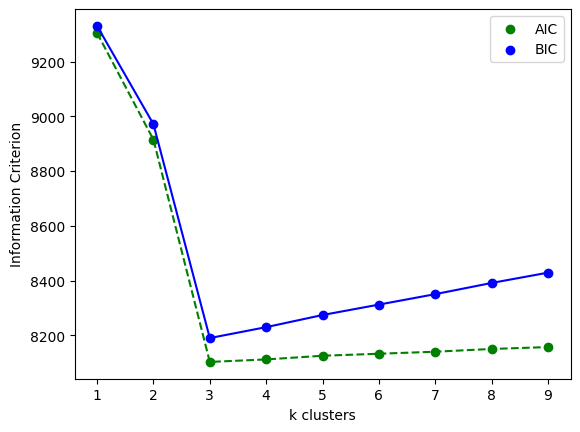

In [14]:
plt.plot(range(1,10), aics, 'g--')
plt.scatter(range(1, 10), aics, c='green', label = 'AIC')
plt.plot(range(1,10), bics, 'b-')
plt.scatter(range(1, 10), bics, c='blue', label = 'BIC')
plt.xlabel('k clusters')
plt.ylabel('Information Criterion')
plt.legend()

As we can see the minimum for both AIC and BIC can be observed at k = 3, hence, this will be our desired number of clusters.

### Bayesian Gaussian Mixture Models

Rather than manually searching for clusters, you use this where you set the number of clusters to a value higher than optimal number and it will automatically set the weights to zero if they are unimportant.

In [15]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

d:\Python\Python312\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [21]:
print(bgm.weights_.round(2))
print(bgm.converged_)

[0.4  0.21 0.   0.4  0.   0.   0.   0.   0.   0.  ]
False


# Application: Anomaly Detection

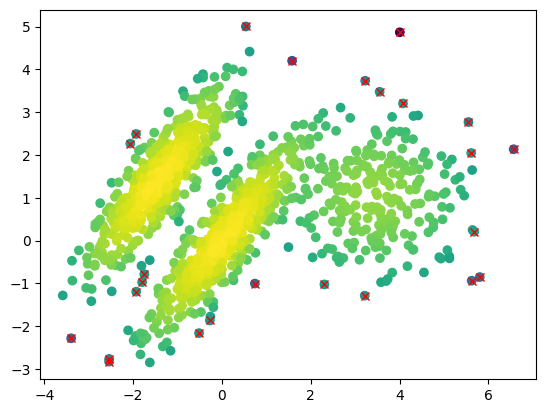

In [279]:
threshold = np.percentile(gm.score_samples(X), 2)
anomaly_idx = np.where(gm.score_samples(X) < threshold)

plt.scatter(X[:,0], X[:,1], c = gm.score_samples(X))
plt.plot(X[anomaly_idx,0], X[anomaly_idx,1], 'rx')

This trick can be used to remove outliers from the data. If there are too many outliers, the model starts to sway, hence, it is best to first fit the data to find those extreme instances and then fit the data again.

### Anomaly detection and Novelty detection

Novelty detection is a closely related task to anomaly detection. For novely detection, it is assumed that the model was clean and had no outliers. For anomaly detection, no such thing is assumed. Outlier detection is often used to clean datasets.

### Some other algoithms for anomaly and novelty detection

1) Fast-MCD (Outlier): <br>
Assumes that data is from a single Gaussian distribution rather than from a mixture and the outliers are not part of that distribution. Implemented by EllipticalEnvelope class.<br>
2) Isolation forest (Outlier) <br>
3) Local outlier factor (Outlier) <br>
4) One-class SVM (Novelty) <br>
5) PCA and other dimensionality reduction techniques with inverse_transform() method: <br>
If you compare the reconstruction error of a normal instance with the reconstruction error of an anomaly, the latter will usually be much larger. This is a simple and often quite efficient anomaly detection approach.